In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import pandas as pd

from PIL import Image, ExifTags
from matplotlib.patches import Rectangle, Polygon

In [2]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

# Data Exploration
Let's take a look at the `train.json` file. It contains all the information using the COCO format.

In [3]:
with open('/content/drive/MyDrive/Proyectos/Waste-Detector/taco-dataset/annotations.json', 'r') as file:
    annotations = json.load(file)

In [4]:
annotations.keys()

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])

In [50]:
categories_df = pd.DataFrame(annotations['categories'])
images_df = pd.DataFrame(annotations['images'])
annotations_df = pd.DataFrame(annotations['annotations'])

In [6]:
images_df

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...
...,...,...,...,...,...,...,...,...,...
1495,1495,1824,4000,batch_9/000095.jpg,CC,https://farm66.staticflickr.com/65535/48701319...,None,None,https://farm66.staticflickr.com/65535/48701319...
1496,1496,1824,4000,batch_9/000096.jpg,CC,https://farm66.staticflickr.com/65535/48701319...,None,None,https://farm66.staticflickr.com/65535/48701319...
1497,1497,4000,1824,batch_9/000097.jpg,CC,https://farm66.staticflickr.com/65535/48694319...,None,None,https://farm66.staticflickr.com/65535/48694319...
1498,1498,1824,4000,batch_9/000098.jpg,CC,https://farm66.staticflickr.com/65535/48693804...,None,None,https://farm66.staticflickr.com/65535/48693804...


In [7]:
data = []

for id in annotations_df['image_id']:
    image_data = images_df[images_df['id'] == id]
    
    file_name = image_data['file_name'].values[0]
    width= image_data['width'].values[0]
    height = image_data['height'].values[0]

    data.append((file_name, width, height))

In [8]:
df = pd.DataFrame(data, columns=['filename', 'width', 'height'])
annotations_df = pd.concat([annotations_df, df], axis=1)

In [9]:
annotations_df

,id,image_id,category_id,segmentation,area,bbox,iscrowd,filename,width,height
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",4.039540e+05,"[517.0, 127.0, 447.0, 1322.0]",0,batch_1/000006.jpg,1537,2049
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1.071260e+06,"[1.0, 457.0, 1429.0, 1519.0]",0,batch_1/000008.jpg,1537,2049
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",9.958350e+04,"[531.0, 292.0, 1006.0, 672.0]",0,batch_1/000008.jpg,1537,2049
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",7.383250e+04,"[632.0, 987.0, 500.0, 374.0]",0,batch_1/000010.jpg,1537,2049
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",9.150000e+02,"[632.0, 989.0, 44.0, 51.0]",0,batch_1/000010.jpg,1537,2049
...,...,...,...,...,...,...,...,...,...,...
4779,4779,1498,16,"[[386, 1557, 635, 1567, 986, 1556, 1178, 1550,...",5.032469e+05,"[228.7143, 1550.0476, 1007.9998999999999, 578....",0,batch_9/000098.jpg,1824,4000
4780,4780,1498,7,"[[1057, 1824, 1041, 1793, 1042, 1758, 1062, 17...",1.449450e+04,"[1041.3334, 1721.7142, 141.0, 138.0]",0,batch_9/000098.jpg,1824,4000
4781,4781,1499,39,"[[1368, 1775, 1099, 1331, 862, 1494, 1099, 1944]]",1.549541e+05,"[862.0274, 1331.25, 505.97260000000006, 612.5]",0,batch_9/000099.jpg,1824,4000
4782,4782,1499,14,"[[1096, 1996, 1121, 2069, 1134, 2127, 1177, 22...",2.867500e+04,"[966.0, 1996.0, 211.0, 336.0]",0,batch_9/000099.jpg,1824,4000


In [11]:
class Config:
    IMGS_PATH = '/content/drive/MyDrive/Proyectos/Waste-Detector/taco-dataset/'

In [12]:
categories_df.head()

,supercategory,id,name
0,Aluminium foil,0,Aluminium foil
1,Battery,1,Battery
2,Blister pack,2,Aluminium blister pack
3,Blister pack,3,Carded blister pack
4,Bottle,4,Other plastic bottle


In [13]:
def get_img(filepath, annotations_df, config = Config):
    #Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

    img_id = annotations_df[annotations_df['filename'] == filepath]['image_id'].values[0]
    I = Image.open(config.IMGS_PATH + filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    return I, img_id

def plot_img(img, annotations_df, img_id):
    df = annotations_df[annotations_df['image_id'] == img_id]

    # Show image
    fig,ax = plt.subplots(1)
    plt.imshow(img)

    for row in df.iterrows():
        data = row[1]
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        for seg in data['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)

        [x, y, w, h] = data['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

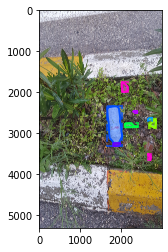

In [14]:
I, img_id = get_img(annotations_df.iloc[900, :]['filename'], annotations_df)
plot_img(I, annotations_df, img_id)

## Group Categories
In this section we are going to group the actual categories into the desired ones:
- plastic 
- carton
- rest
- glass
- other
- organic
- dangerous

In [51]:
replacements = {
    'Foam food container': 'plastic',
    'Squeezable tube': 'plastic',
    'Metal lid': 'plastic',
    'Egg carton': 'carton',
    'Spread tub': 'plastic',
    'Paper bag': 'plastic',
    'Normal paper': 'carton',
    'Tissues': 'rest',
    'Plastic straw': 'plastic',
    'Single-use carrier bag': 'plastic',
    'Scrap metal': 'other',
    'Crisp packet': 'plastic',
    'Styrofoam piece': 'carton',
    'Glass bottle': 'glass',
    'Drink can': 'plastic',
    'Other plastic cup': 'plastic',
    'Battery': 'dangerous',
    'Paper cup': 'carton',
    'Polypropylene bag': 'plastic',
    'Rope & strings': 'rest',
    'Food Can': 'plastic',
    'Plastic lid': 'plastic',
    'Wrapping paper': 'carton',
    'Clear plastic bottle': 'plastic',
    'Other plastic wrapper': 'plastic',
    'Carded blister pack': 'carton',
    'Corrugated carton': 'carton',
    'Foam cup': 'plastic',
    'Magazine paper': 'carton',
    'Broken glass': 'glass',
    'Paper straw': 'carton',
    'Other plastic bottle': 'plastic',
    'Metal bottle cap': 'glass',
    'Unlabelled litter': 'other',
    'Garbage bag': 'rest',
    'Plastic bottle cap': 'plastic',
    'Shoe': 'rest',
    'Other plastic': 'plastic',
    'Plastified paper bag': 'plastic',
    'Tupperware': 'plastic',
    'Plastic glooves': 'plastic',
    'Six pack rings': 'plastic',
    'Glass cup': 'glass',
    'Disposable plastic cup': 'plastic',
    'Plastic film': 'plastic',
    'Pizza box': 'carton',
    'Meal carton': 'carton',
    'Plastic utensils': 'plastic',
    'Disposable food container': 'plastic',
    'Cigarette': 'rest',
    'Food waste': 'organic',
    'Other carton': 'carton',
    'Glass jar': 'glass',
    'Toilet tube': 'carton',
    'Other plastic container': 'plastic',
    'Pop tab': 'plastic',
    'Aluminium blister pack': 'plastic',
    'Aerosol': 'plastic',
    'Aluminium foil': 'plastic',
    'Drink carton': 'carton',
    'Unlabeled litter': 'other'
}

In [52]:
categories_df['new_cat'] = categories_df['name'].replace(replacements)
categories_df.head()

,supercategory,id,name,new_cat
0,Aluminium foil,0,Aluminium foil,plastic
1,Battery,1,Battery,dangerous
2,Blister pack,2,Aluminium blister pack,plastic
3,Blister pack,3,Carded blister pack,carton
4,Bottle,4,Other plastic bottle,plastic


In [53]:
categories_df['new_cat'].value_counts()

plastic      32
carton       14
rest          5
glass         5
other         2
organic       1
dangerous     1
Name: new_cat, dtype: int64

In [54]:
new_categories = {}

for idx, cat in enumerate(pd.unique(categories_df['new_cat'])):
    if cat not in new_categories:
        new_categories[cat] = idx

new_categories

{'carton': 2,
 'dangerous': 1,
 'glass': 3,
 'organic': 4,
 'other': 6,
 'plastic': 0,
 'rest': 5}

In [55]:
categories_replacements = {}

for cat in new_categories:
    old_categories = categories_df[categories_df['new_cat'] == cat]['id']

    for old_cat in old_categories:
        if old_cat not in categories_replacements:
            categories_replacements[old_cat] = new_categories[cat]

In [56]:
annotations_df['category_id'] = annotations_df['category_id'].replace(categories_replacements)
annotations_df['category_id'].value_counts()

0    2586
5     776
2     541
6     537
3     334
4       8
1       2
Name: category_id, dtype: int64

Both the category 1 (dangerous) and 4 (organic) are heavily underrepresented in the dataset. That means the algorithm will not be able to recognize them.